In [1]:
import seaborn
import matplotlib.style
import matplotlib as mpl

mpl.style.use('default')
mpl.style.use('seaborn-colorblind')

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from lightkurve import search_lightcurvefile
from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare
from altaipony.ffd import FFD

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.helper import read_custom_aperture_lc
from funcs.multiperiod import find_period, fetch_lightcurve, remove_sinusoidal

from altaipony.lcio import from_path, from_mast

from find_and_characterize_flares import custom_detrend

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [3]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
target = lcs.loc[2]
target

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
GRP                        1.54
plxmas                  90.0357
eplxmas                0.222697
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms               34.8422
e_vsini_kms                   3
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar   

In [11]:
flcs = from_mast(f"{target.prefix} {target.ID}",
                 cadence="short",
                 c=target.QCS,
                 mission=target.mission.upper())

Found cached file /home/eilin/.lightkurve-cache/mastDownload/TESS/tess2019085135100-s0010-0000000044984200-0140-s/tess2019085135100-s0010-0000000044984200-0140-s_lc.fits with expected size 1920960.
4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
4% (815/18900) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


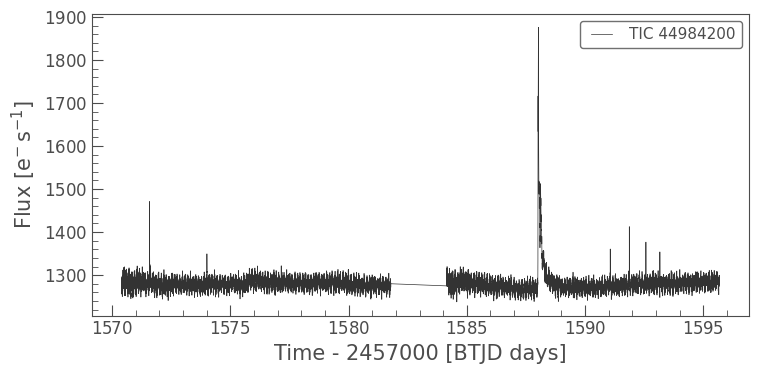

In [12]:
flc=flcs
flc.plot()

In [13]:
flc

FlareLightCurve(ID: 44984200)

In [14]:
# flc = from_mast(f"{target.prefix} {target.ID}", cadence="short", c=sec, mission="TESS")

# flc.plot()
flcc = custom_detrend(flc, target=target)
subsec = 0
flares = flcc.find_flares().flares
flares["ID"] = target.ID
flares["sector"] = target.QCS
flares["subsector"] = subsec
flares["dur"] = flares.tstop - flares.tstart


print("Before loading extra events: ", flc.fake_flares.shape[0])

outpath = f"{CWD}/analysis/results/flarefind/{target.ID}_s{target.QCS}_{subsec}_fake_flares.csv"
flc.load_injrec_data(outpath)
flc.fake_flares = flc.fake_flares.drop_duplicates(keep=False).astype(float)

print("After loading extra events: ", flc.fake_flares.shape[0])

TIC 44984200 modulation period:  2.7116758233095872 h
Relative amplitude of modulation: 8.4e-03


Found 1 candidate(s) in the (0,8153) gap.
Found 1 candidate(s) in the (8153,16428) gap.


Before loading extra events:  0
After loading extra events:  2000


In [15]:
flc.flares = flares
flc.flares["dur"] = flc.flares.tstop - flc.flares.tstart
flc.fake_flares["dur"] = flc.fake_flares.tstop - flc.fake_flares.tstart
flc.fake_flares

,duration_d,amplitude,ed_inj,peak_time,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,total_n_valid_data_points,dur
0,0.054272,0.467422,2002.010672,1574.879866,3187.0,3355.0,NaN,NaN,1574.861375,1575.094706,1846.504209,5.707542,0.441391,16428.0,0.233332
1,0.050076,0.210482,831.711542,1593.998178,15203.0,15302.0,NaN,NaN,1593.981951,1594.119448,738.228866,5.097350,0.207974,16428.0,0.137497
2,0.048114,0.559860,2127.412367,1570.844872,291.0,443.0,NaN,NaN,1570.828064,1571.040563,1972.066633,5.410406,0.543702,16428.0,0.212499
3,0.037387,0.281909,832.222680,1586.444522,9787.0,9862.0,NaN,NaN,1586.432069,1586.536235,677.293266,4.291492,0.275360,16428.0,0.104165
4,0.009650,0.562187,425.425673,1579.612026,6589.0,6623.0,NaN,NaN,1579.608553,1579.655774,405.269051,2.490945,0.461912,16428.0,0.047222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.011286,0.072818,65.389870,1594.034764,15240.0,15250.0,NaN,NaN,1594.033339,1594.047227,46.721179,1.790821,0.084924,16428.0,0.013889
1996,0.011414,0.037238,33.522343,1570.921451,357.0,361.0,NaN,NaN,1570.921119,1570.926674,12.788491,1.267417,0.032467,16428.0,0.005556
1997,0.007000,0.026745,14.953285,1585.430827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,0.013260,0.086306,90.085099,1593.924477,15159.0,15177.0,NaN,NaN,1593.920841,1593.945840,71.038482,2.369896,0.078565,16428.0,0.025000


[0.0080171  0.05256849 0.09711987 0.14167126 0.18622264 0.23077402
 0.27532541 0.31987679 0.36442817 0.40897956 0.45353094 0.49808233
 0.54263371 0.58718509 0.63173648 0.67628786 0.72083924 0.76539063
 0.80994201 0.8544934  0.89904478 0.94359616 0.98814755 1.03269893
 1.07725031 1.1218017  1.16635308 1.21090447 1.25545585 1.30000723
 1.34455862 1.38911   ] [2.09819630e-04 2.79804495e-02 5.57510793e-02 8.35217092e-02
 1.11292339e-01 1.39062969e-01 1.66833599e-01 1.94604229e-01
 2.22374858e-01 2.50145488e-01 2.77916118e-01 3.05686748e-01
 3.33457378e-01 3.61228008e-01 3.88998637e-01 4.16769267e-01
 4.44539897e-01 4.72310527e-01 5.00081157e-01 5.27851787e-01
 5.55622416e-01 5.83393046e-01 6.11163676e-01 6.38934306e-01
 6.66704936e-01 6.94475566e-01 7.22246196e-01 7.50016825e-01
 7.77787455e-01 8.05558085e-01 8.33328715e-01 8.61099345e-01]
[0.0080171  0.05256849 0.09711987 0.14167126 0.18622264 0.23077402
 0.27532541 0.31987679 0.36442817 0.40897956 0.45353094 0.49808233
 0.54263371 0.5871

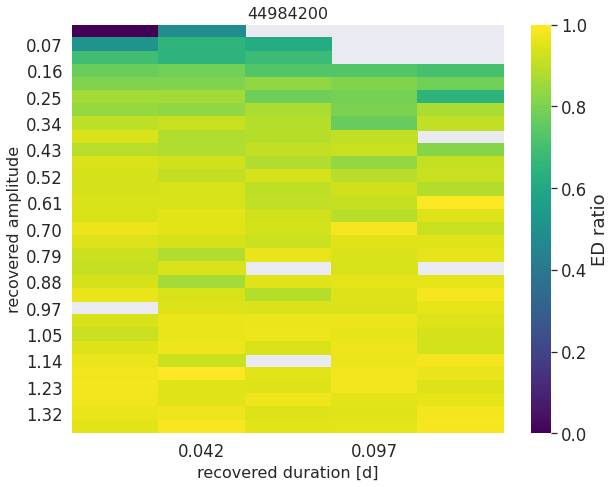

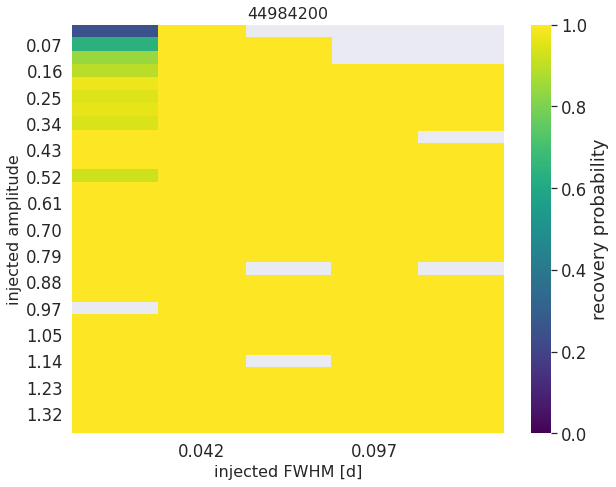

In [19]:
density = 2
dur_bins = None
ampl_bins = None
flc = flc.characterize_flares(flares_per_bin=density, dur_bins=dur_bins, ampl_bins=ampl_bins)

flc.plot_ed_ratio_heatmap(flares_per_bin=density, dur_bins=dur_bins, ampl_bins=ampl_bins)

flc.plot_recovery_probability_heatmap(flares_per_bin=density, dur_bins=dur_bins, ampl_bins=ampl_bins)

In [ ]:
plt.scatter(flc.flares.ed_rec,flc.flares.ed_corr )
# plt.xscale("log")

In [ ]:
flc.flares.T

# View an save characterized flares

In [ ]:
for i, r in flc.flares.iterrows():
    plt.figure(figsize=(5,4))
    plt.plot(flc.time, flc.flux,c="k",alpha=.6)
    plt.plot(flcc.time, flcc.detrended_flux,c="b",label=f"{r.tstart:.2f}")
    sta, sto = r.tstart, r.tstop
    plt.xlim(r.tstart-.3,r.tstop+.3)
    t = np.linspace(r.tstart-.3,r.tstop+.3,3000)
    wh = (flcc.time>=sta) & (flcc.time<=sto)
    plt.plot(t,
             np.mean(flcc.flux)+
             np.mean(flc.flux)*aflare(t, flcc.time[wh][np.argmax(flcc.detrended_flux[wh])], 
                    r.duration_corr, r.amplitude_corr,),c="r",alpha=.8)
    plt.ylim(np.nanmin(1.*flcc.detrended_flux),1600)#1.*np.nanmax(f.detrended_flux))

    plt.legend()

In [ ]:
flc.flares["real"] = 1

In [ ]:
with open(f"{CWD}/analysis/results/flarefind/2020_08_all_flares.csv", "a") as f:
    flc.flares.to_csv(f, index=False, header=False)

# FFD analysis

In [ ]:
df = pd.read_csv(f"{CWD}/analysis/results/flarefind/2020_08_all_flares.csv")
subdf = df[(df.ID == target.ID) &
        (df.real == 1) ]#&
#        (df.sector == target.QCS)]

In [ ]:
len(flc.time)/60./24./365.25

In [ ]:
def plot_ffds(flc, ax, subdf):

    # Show the uncorrected flare sample
    f = pd.DataFrame({"ed_rec":subdf.ed_rec})
    ffd = FFD(f=f, tot_obs_time=len(flc.time)/60./24./365.25)
    ed, freq, counts = ffd.ed_and_freq()
    ax.scatter(ed, freq, c="grey", marker="d")

    # Show the corrected flare sample
    f = pd.DataFrame({"ed_rec":subdf.ed_corr.dropna()})
    ffd = FFD(f=f, tot_obs_time=len(flc.time)/60./24./365.25)
    ed, freq, counts = ffd.ed_and_freq()
    ax.scatter(ed, freq, c="k")

    # Fit a powerlaw and plot it
    ffd.fit_powerlaw("mmle")
    ffd.plot_powerlaw(ax=ax)

In [ ]:
results = {}

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5),)

# Plot FFDs and fit powerlaw
plot_ffds(flc, ax, subdf)

# save results to dict
results[target.ID] = {"alpha":ffd.alpha,
                      "alpha_up_err":ffd.alpha_err,
                      "alpha_low_err":ffd.alpha_err,
                      "beta":ffd.beta,
                      "beta_up_err":ffd.beta_err,
                      "beta_low_err":ffd.beta_err,}

# layout
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per year")


plt.tight_layout()

In [ ]:
pd.DataFrame(results)

# How often would such a flare occur?

In [ ]:
CWD = "/".join(os.getcwd().split("/")[:-2])
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
df = df.drop_duplicates(keep=False).fillna("")
df

In [ ]:
df[df.ID==target.ID]
# Get uncertainties here, too!
# ED_s_50, s_84, s_16
ffd.beta / (ffd.alpha - 1.) * np.power(ED,-ffd.alpha+1)

# Does the amplitude duration ratio fit in with the rest of the flares from that star?

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5),)

ax.scatter(subdf.duration_corr,subdf.amplitude_corr, marker="x")
ax.set_ylabel("corrected amplitude")
ax.set_ylabel("corrected FWHM")